In [1]:
import importlib
import sys
sys.path.append('../src')

import qa
importlib.reload(qa)
import qa
from qa import QA

import pickle

In [2]:
# from datasets import load_dataset

# ds = load_dataset("TIGER-Lab/MMLU-Pro")

# mmlu = {}
# for ele in ds['test']:
#     if ele['category'] not in mmlu:
#         mmlu[ele['category']] = []
#     mmlu[ele['category']].append(ele)

# import random

# mmlu_samples = []
# for cat in mmlu:
#     mmlu_samples.extend(random.Random(0).sample(mmlu[cat], 10))

# with open('../data/mmlu_samples_140.pkl', 'wb') as f:
#     pickle.dump(mmlu_samples, f)

with open('../data/mmlu_samples_140.pkl', 'rb') as f:
    mmlu_samples = pickle.load(f)

In [ ]:
with open('../data/res_mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)


for agree_size in [0,1,2,3,4]:
    for disagree_size in [0,1,2,3,4]:
        eval_feat = {
            'type': 'grp',
            'agree_size': agree_size,
            'disagree_size': disagree_size,
            'disagree_type': '2nd',
        }

        res_mmlu_grp_2nd = qa.mmlu_eval(res_mmlu_org, eval_feat)


Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 828212.36it/s]

Eval Type:grp, #Agree: 0, #Disagree: 0, Disagree Type: 2nd, Accuracy: 0.45



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1644825.10it/s]

Eval Type:grp, #Agree: 0, #Disagree: 1, Disagree Type: 2nd, Accuracy: 0.364



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1176758.64it/s]

Eval Type:grp, #Agree: 0, #Disagree: 2, Disagree Type: 2nd, Accuracy: 0.386



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1174405.12it/s]

Eval Type:grp, #Agree: 0, #Disagree: 3, Disagree Type: 2nd, Accuracy: 0.371



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1343712.95it/s]

Eval Type:grp, #Agree: 0, #Disagree: 4, Disagree Type: 2nd, Accuracy: 0.386



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1371968.60it/s]

Eval Type:grp, #Agree: 1, #Disagree: 0, Disagree Type: 2nd, Accuracy: 0.464



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 717851.54it/s]

Eval Type:grp, #Agree: 1, #Disagree: 1, Disagree Type: 2nd, Accuracy: 0.436



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 654629.39it/s]

Eval Type:grp, #Agree: 1, #Disagree: 2, Disagree Type: 2nd, Accuracy: 0.421



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 651000.62it/s]

Eval Type:grp, #Agree: 1, #Disagree: 3, Disagree Type: 2nd, Accuracy: 0.421



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1591334.85it/s]

Eval Type:grp, #Agree: 1, #Disagree: 4, Disagree Type: 2nd, Accuracy: 0.436



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1846548.93it/s]

Eval Type:grp, #Agree: 2, #Disagree: 0, Disagree Type: 2nd, Accuracy: 0.464



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 2796202.67it/s]

Eval Type:grp, #Agree: 2, #Disagree: 1, Disagree Type: 2nd, Accuracy: 0.436



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1475383.32it/s]

Eval Type:grp, #Agree: 2, #Disagree: 2, Disagree Type: 2nd, Accuracy: 0.436



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 429555.64it/s]

Eval Type:grp, #Agree: 2, #Disagree: 3, Disagree Type: 2nd, Accuracy: 0.421



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1505647.59it/s]

Eval Type:grp, #Agree: 2, #Disagree: 4, Disagree Type: 2nd, Accuracy: 0.4



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1509518.15it/s]

Eval Type:grp, #Agree: 3, #Disagree: 0, Disagree Type: 2nd, Accuracy: 0.464



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1970478.39it/s]

Eval Type:grp, #Agree: 3, #Disagree: 1, Disagree Type: 2nd, Accuracy: 0.443



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1537179.48it/s]

Eval Type:grp, #Agree: 3, #Disagree: 2, Disagree Type: 2nd, Accuracy: 0.443



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1398101.33it/s]

Eval Type:grp, #Agree: 3, #Disagree: 3, Disagree Type: 2nd, Accuracy: 0.421



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1706984.19it/s]

Eval Type:grp, #Agree: 3, #Disagree: 4, Disagree Type: 2nd, Accuracy: 0.414



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1918962.61it/s]

Eval Type:grp, #Agree: 4, #Disagree: 0, Disagree Type: 2nd, Accuracy: 0.464



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1668189.09it/s]

Eval Type:grp, #Agree: 4, #Disagree: 1, Disagree Type: 2nd, Accuracy: 0.45



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1846548.93it/s]

Eval Type:grp, #Agree: 4, #Disagree: 2, Disagree Type: 2nd, Accuracy: 0.443



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1059932.42it/s]

Eval Type:grp, #Agree: 4, #Disagree: 3, Disagree Type: 2nd, Accuracy: 0.471



Processing MMLU: 100%|██████████| 140/140 [00:00<00:00, 1208235.72it/s]

Eval Type:grp, #Agree: 4, #Disagree: 4, Disagree Type: 2nd, Accuracy: 0.436


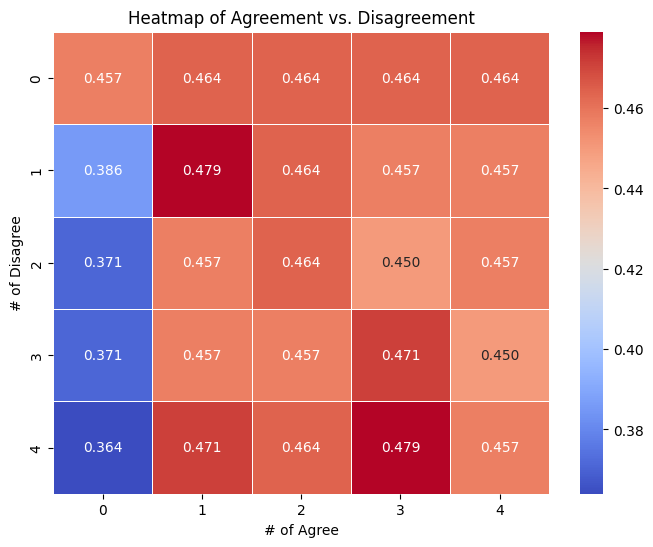

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = np.array([
    [0.457, 0.464, 0.464, 0.464, 0.464],
    [0.386, 0.479, 0.464, 0.457, 0.457],
    [0.371, 0.457, 0.464, 0.45, 0.457],
    [0.371, 0.457, 0.457, 0.471, 0.45],
    [0.364, 0.471, 0.464, 0.479, 0.457]
])

# Define row and column labels
row_labels = ["0", "1", "2", "3", "4"]
col_labels = ["0", "1", "2", "3", "4"]

# Create DataFrame
df = pd.DataFrame(data, index=row_labels, columns=col_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.xlabel("# of Agree")
plt.ylabel("# of Disagree")
plt.title("Heatmap when Agree is Shown First")
plt.show()

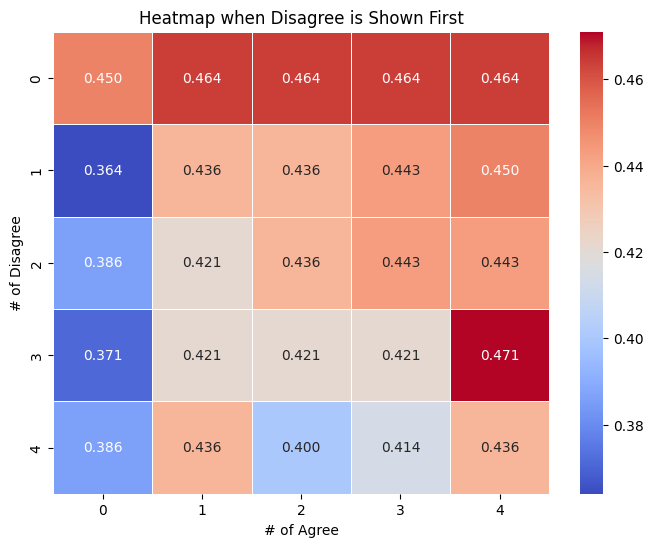

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
data = np.array([
    [0.45 , 0.464 , 0.464 , 0.464 , 0.464 ],
    [0.364 , 0.436 , 0.436 , 0.443 , 0.45 ],
    [0.386 , 0.421 , 0.436 , 0.443 , 0.443 ],
    [0.371 , 0.421 , 0.421 , 0.421 , 0.471 ],
    [0.386 , 0.436 , 0.4 , 0.414 , 0.436 ],
])

# Define row and column labels
row_labels = ["0", "1", "2", "3", "4"]
col_labels = ["0", "1", "2", "3", "4"]

# Create DataFrame
df = pd.DataFrame(data, index=row_labels, columns=col_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.xlabel("# of Agree")
plt.ylabel("# of Disagree")
plt.title("Heatmap when Disagree is Shown First")
plt.show()